In [1]:
!nvidia-smi

Sat Oct 10 21:36:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
from PIL.Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!wget -q 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
!wget -q 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'

In [5]:
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        h, w = img.size
        scale = self.size/max(h,w)
        scaled = round(scale*min(h,w))
        return transforms.functional.resize(img, scaled)

In [6]:
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

loader = transforms.Compose([
            ResizeTransform(512),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
])
unloader = transforms.Compose([
            transforms.Normalize(mean=-mean/std, std=1/std),
            transforms.ToPILImage(),
])

In [7]:
def load_img(path):
    img = PIL.Image.open(path)
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)

In [8]:
style_img = load_img("Vassily_Kandinsky,_1913_-_Composition_7.jpg")
content_img = load_img("YellowLabradorLooking_new.jpg")

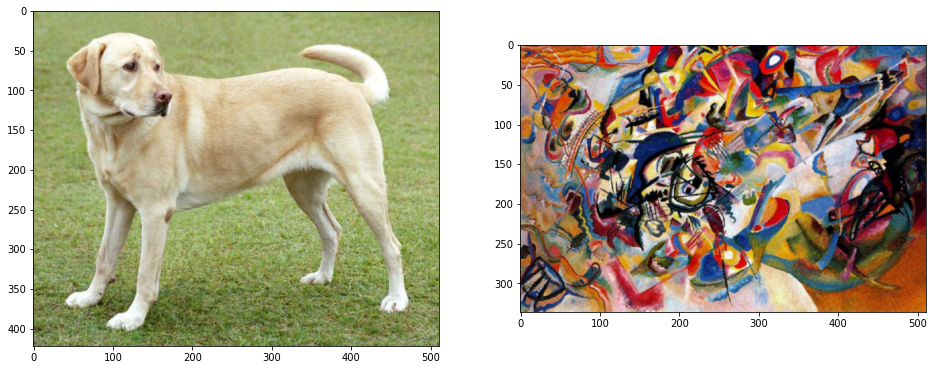

In [9]:
plt.figure(figsize=[16,32])
plt.subplot(1, 2, 1)
plt.imshow(unloader(content_img[0].cpu()))
plt.subplot(1, 2, 2)
plt.imshow(unloader(style_img[0].cpu()))
plt.show()

In [10]:
vgg = torchvision.models.vgg19(pretrained=True, progress=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad_(False)

In [11]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
style_layers = np.array([1,6,11,20,29])
content_layers = np.array([31])
style_layers, content_layers

(array([ 1,  6, 11, 20, 29]), array([31]))

In [13]:
def tensor_to_img(tensor):
    return unloader(tensor[0].cpu())

In [14]:
def gram_matrix(input_tensor):
    b, c, i, j = input_tensor.size()
    # result = torch.einsum("bcij,bdij->bcd", input_tensor, input_tensor)
    # result = torch.tensordot(input_tensor, input_tensor, ((2, 3), (2, 3)))
    input_tensor = input_tensor.view(c, i * j)
    result = torch.mm(input_tensor, input_tensor.t())
    return result/(i * j)

In [27]:
class StyleContentModel(nn.Module):
    def __init__(self, style_layers, content_layers, model=None):
        super().__init__()
        if model is None:
            self.model = torchvision.models.vgg19(pretrained=True, progress=True).features.to(device).eval()
            for param in self.model.parameters():
                param.require_grad_(False)
        else:
            self.model = model
        self.style_layers = style_layers
        self.content_layers = content_layers
    
    def forward(self, x):
        style_outputs = []
        content_outputs = []
        for i, lyr in self.model._modules.items():
            x = lyr(x)
            i = int(i)
            if i in self.style_layers:
                style_outputs.append(x)
            if i in self.content_layers:
                content_outputs.append(x)
        style_outputs = [gram_matrix(sto) for sto in style_outputs]
        content_dict = {content:value
                        for content, value in zip(self.content_layers, content_outputs)}
        style_dict = {style:value
                        for style, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [28]:
extractor = StyleContentModel(style_layers, content_layers, vgg)

In [29]:
style_targets = extractor(style_img)['style']
for t in style_targets.values():
    t.detach_()
content_targets = extractor(content_img)['content']
for t in content_targets.values():
    t.detach_()

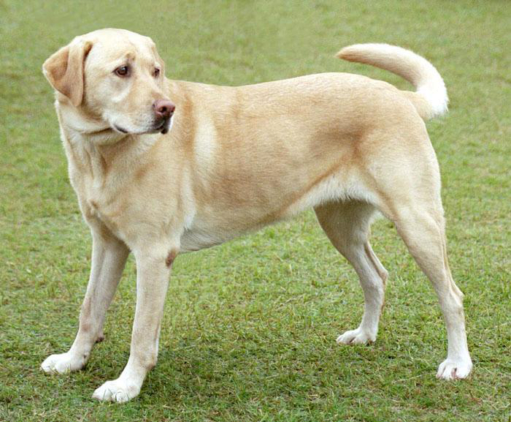

In [37]:
image = content_img.clone().to(device)
image.requires_grad_(True)
tensor_to_img(image)

In [38]:
optimizer = optim.Adam([image], lr=0.004, betas=(0.99,  0.999), eps=1e-2)

In [39]:
style_weight=1e4
content_weight=1e-2

In [40]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = 0
    stls = [torch.mean(
        (style_outputs[name] - style_targets[name])**2
        ) for name in style_outputs.keys()]
    for sl in stls:
        style_loss += sl
    content_loss = 0
    ctls = [torch.mean(
        (content_outputs[name] - content_targets[name])**2
        ) for name in content_outputs.keys()]
    for cl in ctls:
        content_loss += cl
    return style_loss*style_weight + content_loss*content_weight

In [41]:
def train_step(img):
    optimizer.zero_grad()
    outputs = extractor(img)
    loss = style_content_loss(outputs)
    loss.backward()
    optimizer.step()
    img.data.clamp_(0, 1)

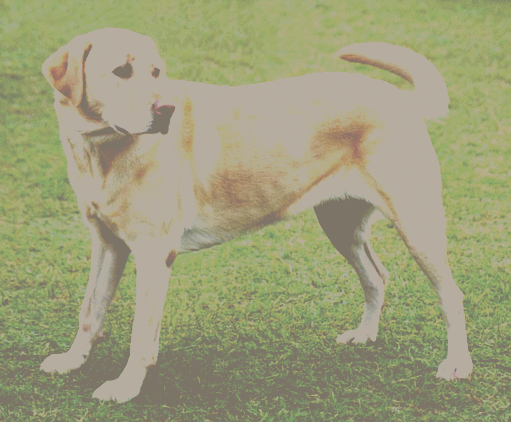

In [42]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_img(image)

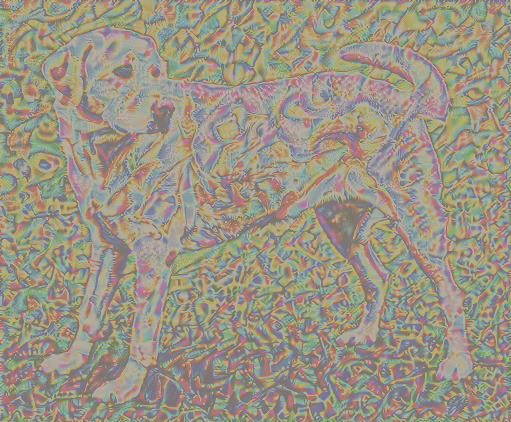

Train step: 1000
Total time: 78.5


In [43]:
import IPython.display as display
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_img(image))
    print(f"Train step: {step}")
  
end = time.time()
print(f"Total time: {end-start:.1f}")